```python
  -- Hardware Info --
  Model Name:	MacBook Pro
  Model Identifier:	MacBookPro11,2
  Processor Name:	Intel Core i7
  Processor Speed:	2.2 GHz
  Number of Processors:	1
  Total Number of Cores:	4
  L2 Cache (per Core):	256 KB
  L3 Cache:	6 MB
  Memory:	16 GB
```

In [2]:
from keras.models import Sequential, Graph
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.layers.convolutional import Convolution1D, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.utils.visualize_util import plot, to_graph
from keras.optimizers import SGD
import cv2, numpy as np
import matplotlib.pyplot as plt
import pickle
import IPython
import time
import urllib2
from IPython.display import SVG

# plot inline
%matplotlib inline

## VGG-16 model

In [3]:
def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model

## Utility functions

In [4]:
# unpickle dictionary to convert ids to human readable labels
imagenet1000_clsid_to_human = pickle.load(urllib2.urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl') )
#pickle.load( open( "imagenet1000_clsid_to_human.pkl", "rb" ) )

# pre-process image to feed to the VGG-16 network, zero-center data by subtacting mean across each channel
def img_preprocess(img):
    im_ = cv2.resize(img, (224, 224)).astype(np.float32)
    im_[:,:,0] -= 103.939
    im_[:,:,1] -= 116.779
    im_[:,:,2] -= 123.68
    im_ = im_.transpose((2,0,1))
    im_ = np.expand_dims(im_, axis=0)
    return im_

# function to get top k probability class ids 
def get_topk(predictions, k=5):
    return (-predictions.squeeze()).argsort()[:k] 

## VGG-16 model with pre-trained weights

In [5]:
start = time.time()
model = VGG_16('vgg16_weights.h5')
end = time.time()
print "VGG-16 weights load from disk: %fs" % (end - start)

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

start = time.time()
model.compile(optimizer=sgd, loss='categorical_crossentropy')
end = time.time()
print "theano graph compile: %fs" % (end - start)

VGG-16 weights load from disk: 4.513973s


/Users/yrevar/virtualenvs/keras/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


theano graph compile: 17.485463s


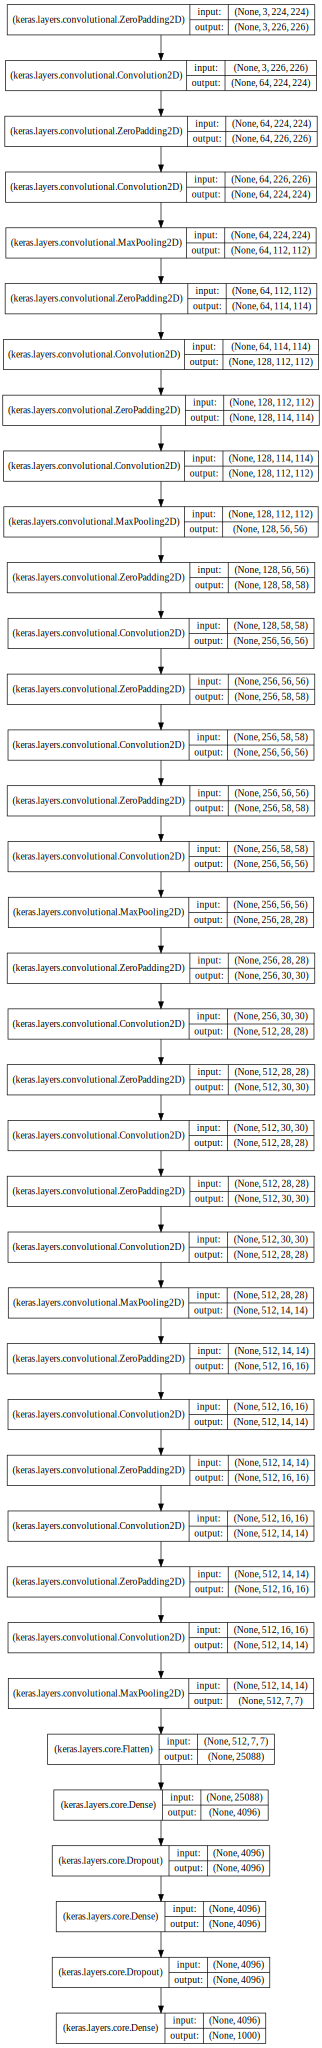

In [6]:
# Visualize model
SVG(to_graph(model, show_shape=True).create(prog='dot', format='svg'))
# alternate method
# plot(model, to_file='model.png', show_shape=True)
# IPython.display.Image('./model.png', width=400)

## Hello NNet: classify customary input cat

<img src="./cat.jpg"> cat.jpg <img>

In [7]:
start = time.time()
predictions = model.predict(img_preprocess(cv2.imread('cat.jpg')))
end = time.time()
print "VGG-16 forward pass: %fs" % (end - start)
topk_ = [imagenet1000_clsid_to_human[i] for i in get_topk(predictions, 5)]

VGG-16 forward pass: 7.113625s


In [8]:
print topk_

['kit fox, Vulpes macrotis', 'red fox, Vulpes vulpes', 'Egyptian cat', 'tiger cat', 'tabby, tabby cat']


## Hello NNet: classify image from live camera feed

In [12]:
cap = cv2.VideoCapture(0)
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Our operations on the frame come here
    #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Display the resulting frame
    cv2.imshow('frame', frame)
    keypress_ = cv2.waitKey(1)
    if keypress_ & 0xFF == ord('c'): # press c to capture image for classifcation
        capture_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        break
    elif keypress_ & 0xFF == ord('q'):
        break
        
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

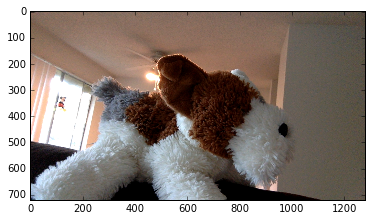

In [14]:
plt.imshow(capture_frame)

In [16]:
predictions = model.predict(img_preprocess(capture_frame))
print [imagenet1000_clsid_to_human[i] for i in get_topk(predictions, 5)]

['wire-haired fox terrier', 'standard poodle', 'teddy, teddy bear', 'Bedlington terrier', 'toy poodle']


## Transfer Learning

### Example 1: Fully Convolutional Net
Create a fully convolutional VGG net and transfer weights from VGG16 pretrained net. Here, we are replacing last fully connected layer with convolutional layer that we will be retraining so we don't transfer learn weights for those layers. 

In [18]:
def VGG_16_FullyConv(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, 7, 7, activation='relu'))
    model.add(Convolution2D(2096, 1, 1, activation='relu')) 
    model.add(Convolution2D(1000, 1, 1)) 
    model.add(Flatten())
    model.add(Activation('softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model

In [15]:
model_fullyconv = VGG_16_FullyConv("./vgg16_fullyconv_weights.h5")

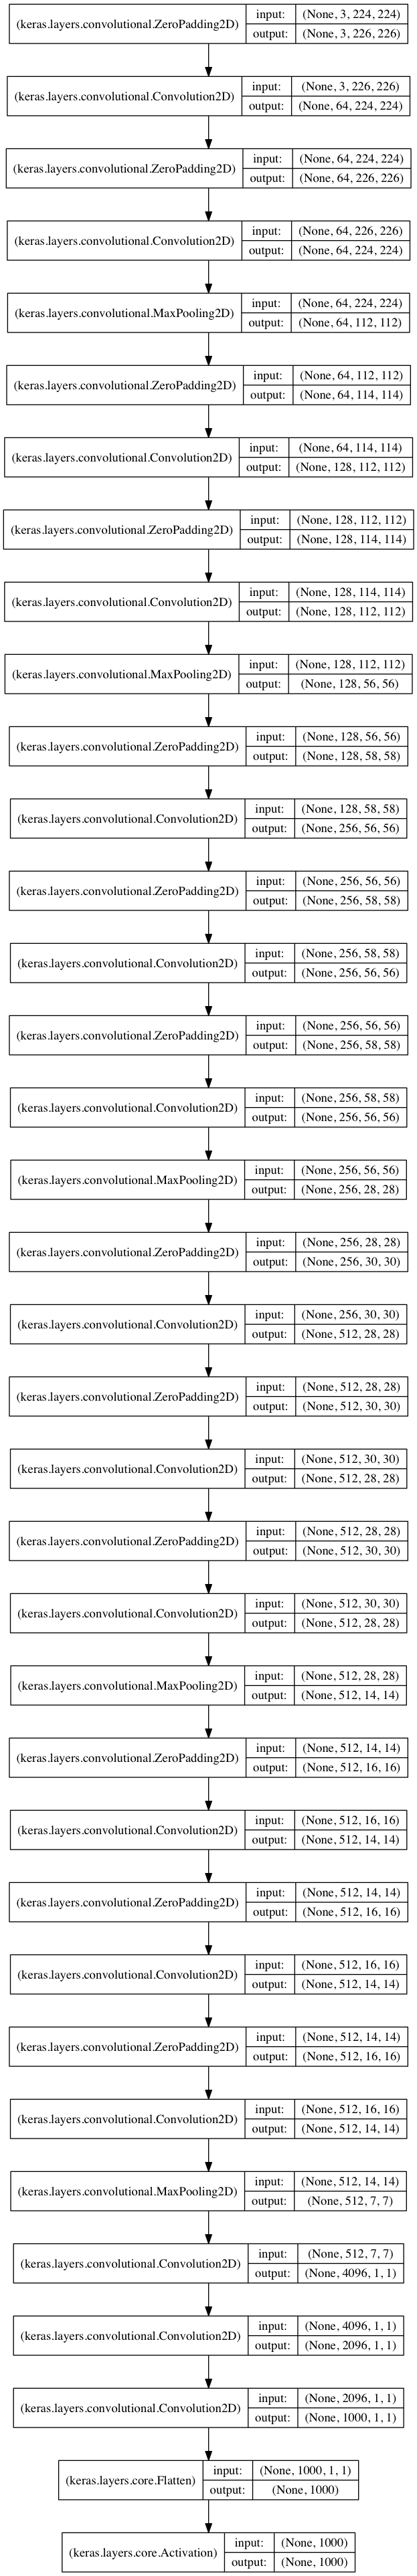

In [11]:
graph = to_graph(model_fullyconv, show_shape=True)
graph.write_png("model.png")
IPython.display.Image("model.png", width=400)

In [12]:
for i in range(len(model.layers)-6):
    if len(model.layers[i].get_weights()):
        model_fullyconv.layers[i].W.set_value(model.layers[i].get_weights()[0])
        model_fullyconv.layers[i].b.set_value(model.layers[i].get_weights()[1])
        model_fullyconv.layers[i].trainable = False

In [13]:
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model_fullyconv.compile(optimizer=sgd, loss='categorical_crossentropy')

In [14]:
model_fullyconv.save_weights("./vgg16_fullyconv_weights.h5")

### Example 2: Multi-label classification

In [26]:
def VGG_16_multilabel(weights_path=None):
    m = Graph()
    
    m.add_input(name='input', input_shape=(3,224,224))
    m.add_node(ZeroPadding2D((1,1)), name="pad0", input="input")
    m.add_node(Convolution2D(64, 3, 3, activation='relu'), name="conv1", input="pad0")
    m.add_node(ZeroPadding2D((1,1)), name="pad1", input="conv1")
    m.add_node(Convolution2D(64, 3, 3, activation='relu'), name="conv2", input="pad1")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp2", input="conv2")

    m.add_node(ZeroPadding2D((1,1)), name="pad2", input="maxp2")
    m.add_node(Convolution2D(128, 3, 3, activation='relu'), name="conv3", input="pad2")
    m.add_node(ZeroPadding2D((1,1)), name="pad3", input="conv3")
    m.add_node(Convolution2D(128, 3, 3, activation='relu'), name="conv4", input="pad3")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp4", input="conv4")

    m.add_node(ZeroPadding2D((1,1)), name="pad4", input="maxp4")
    m.add_node(Convolution2D(256, 3, 3, activation='relu'), name="conv5", input="pad4")
    m.add_node(ZeroPadding2D((1,1)), name="pad5", input="conv5")
    m.add_node(Convolution2D(256, 3, 3, activation='relu'), name="conv6", input="pad5")
    m.add_node(ZeroPadding2D((1,1)), name="pad6", input="conv6")
    m.add_node(Convolution2D(256, 3, 3, activation='relu'), name="conv7", input="pad6")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp7", input="conv7")

    m.add_node(ZeroPadding2D((1,1)), name="pad7", input="maxp7")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv8", input="pad7")
    m.add_node(ZeroPadding2D((1,1)), name="pad8", input="conv8")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv9", input="pad8")
    m.add_node(ZeroPadding2D((1,1)), name="pad9", input="conv9")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv10", input="pad9")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp10", input="conv10")
    
    m.add_node(ZeroPadding2D((1,1)), name="pad10", input="maxp10")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv11", input="pad10")
    m.add_node(ZeroPadding2D((1,1)), name="pad11", input="conv11")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv12", input="pad11")
    m.add_node(ZeroPadding2D((1,1)), name="pad12", input="conv12")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv13", input="pad12")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp13", input="conv13")
    
    m.add_node(Flatten(), name="fork", input="maxp13")
    
    m.add_node(Dense(2048, activation='relu'), name="h1fc1", input="fork")
    m.add_node(Dropout(0.5), name="h1fc1_drop", input="h1fc1")
    m.add_node(Dense(1024, activation='relu'), name="h1fc2", input="h1fc1_drop")
    m.add_node(Dropout(0.5), name="h1fc2_drop", input="h1fc2")
    m.add_node(Dense(7, activation='softmax'), name="h1out", input="h1fc2_drop")
    
    m.add_node(Dense(2048, activation='relu'), name="h2fc1", input="fork")
    m.add_node(Dropout(0.5), name="h2fc1_drop", input="h2fc1")
    m.add_node(Dense(1024, activation='relu'), name="h2fc2", input="h2fc1_drop")
    m.add_node(Dropout(0.5), name="h2fc2_drop", input="h2fc2")
    m.add_node(Dense(7, activation='softmax'), name="h2out", input="h2fc2_drop")
    
    m.add_node(Dense(2048, activation='relu'), name="h3fc1", input="fork")
    m.add_node(Dropout(0.5), name="h3fc1_drop", input="h3fc1")
    m.add_node(Dense(1024, activation='relu'), name="h3fc2", input="h3fc1_drop")
    m.add_node(Dropout(0.5), name="h3fc2_drop", input="h3fc2")
    m.add_node(Dense(7, activation='softmax'), name="h3out", input="h3fc2_drop")
    
    m.add_node(Dense(2048, activation='relu'), name="h4fc1", input="fork")
    m.add_node(Dropout(0.5), name="h4fc1_drop", input="h4fc1")
    m.add_node(Dense(1024, activation='relu'), name="h4fc2", input="h4fc1_drop")
    m.add_node(Dropout(0.5), name="h4fc2_drop", input="h4fc2")
    m.add_node(Dense(7, activation='softmax'), name="h4out", input="h4fc2_drop")
    
    m.add_node(Dense(2048, activation='relu'), name="h5fc1", input="fork")
    m.add_node(Dropout(0.5), name="h5fc1_drop", input="h5fc1")
    m.add_node(Dense(1024, activation='relu'), name="h5fc2", input="h5fc1_drop")
    m.add_node(Dropout(0.5), name="h5fc2_drop", input="h5fc2")
    m.add_node(Dense(7, activation='softmax'), name="h5out", input="h5fc2_drop")
    
    m.add_node(Dense(2048, activation='relu'), name="h6fc1", input="fork")
    m.add_node(Dropout(0.5), name="h6fc1_drop", input="h6fc1")
    m.add_node(Dense(1024, activation='relu'), name="h6fc2", input="h6fc1_drop")
    m.add_node(Dropout(0.5), name="h6fc2_drop", input="h6fc2")
    m.add_node(Dense(7, activation='softmax'), name="h6out", input="h6fc2_drop")
    
    m.add_node(Dense(2048, activation='relu'), name="h7fc1", input="fork")
    m.add_node(Dropout(0.5), name="h7fc1_drop", input="h7fc1")
    m.add_node(Dense(1024, activation='relu'), name="h7fc2", input="h7fc1_drop")
    m.add_node(Dropout(0.5), name="h7fc2_drop", input="h7fc2")
    m.add_node(Dense(7, activation='softmax'), name="h7out", input="h7fc2_drop")
    
    m.add_output(name='output1', input='h1out')
    m.add_output(name='output2', input='h2out')
    m.add_output(name='output3', input='h3out')
    m.add_output(name='output4', input='h4out')
    m.add_output(name='output5', input='h5out')
    m.add_output(name='output6', input='h6out')
    m.add_output(name='output7', input='h7out')

    if weights_path:
        m.load_weights(weights_path)

    return m

In [ ]:
multilabel_classification_sample = VGG_16_multilabel()

In [ ]:
plot(multilabel_classification_sample, to_file='graph.png', show_shape=True)
IPython.display.Image('./graph.png', width=1200)